In [19]:
import pandas as pd
import requests
import yfinance as yf
import investpy
from bs4 import BeautifulSoup
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [20]:
class Accion:
    def __init__(self, mercado, datosAccion):
        self.nombre = datosAccion[mercado.campo_nombre]
        self.max = datosAccion[mercado.campo_valorMaximo]
        self.min = datosAccion[mercado.campo_valorMinimo]
        self.ult = datosAccion[mercado.campo_UltimoPrecio]
        self.mov = datosAccion[mercado.campo_cambio]
        
class Origen:
    def __init__(self):
        self.__abrirColeccion()

    def __abrirColeccion(self):
        client = MongoClient('localhost')
        bd = client['cotizaciones']
        self.coleccion = bd[self.__class__.__name__]
        
    def _guardarEnBD(self, dataFrame):
        self.coleccion.drop()
        self.coleccion.insert_many(dataFrame.to_dict('records'))
        
    def visualizarBD(self):
        for documento in self.coleccion.find({}):
            print(documento)
            
    def visualizarDF(self):
        df = self.__documentADF(self.coleccion.find({}))
        #print (df)
        return df

    def __documentADF(self, listColeccion):
        df = pd.DataFrame(list(listColeccion))
        return df.drop(['_id'], axis=1)
        
    def gananciaPerdidaAcciones(self,columna,cantidad):
        df = self.visualizarDF()
        df = df.sort_values(by=columna, ascending = False)
        print()
        print("Acciones de mayor ganancia\n",df.head(cantidad))
        print()
        print("Acciones de mayor pérdida\n",df.tail(cantidad))
    
    #vamos a graficar los valores positivos de un color y los negativos de otro color
    def graficarGananciaPerdida(self,x,y,titulo,nombre):
        df = self.visualizarDF()
        dfPositivos = df[df[y]>=0].rename({y: 'Ganancia'}, axis=1)#filtramos las acciones con ganancia
        dfNegativos = df[df[y]<0 ].rename({y: 'Pérdida'}, axis=1)#filtramos las acciones con pérdida
        df = pd.concat([dfPositivos,dfNegativos]).sort_values(by=x)   #unimos las tablas ordenadas por el nombre
        #armamos el gráfico 
        plt.style.use('seaborn') #estilo grafico
        df[[x, 'Ganancia', 'Pérdida']].plot(x, kind="bar", width=1, color=["#04D8B2","#EF4026"]) #parámetros: columnas, tipo de gráfico, ancho de las barras, colores de las barras
        plt.title(titulo) #título del grafico
        plt.xlabel('Acciones') #título del eje de las x
        plt.savefig(nombre, bbox_inches='tight') #guardamos el gráfico, 'tight' para guardarlo completo [parámetro: nombre]
        plt.tight_layout();plt.show() #mostramos el gráfico de manera completa

    def filtrarAcciones(self, nombreAccion):
        accion = self.coleccion.find({self.campo_nombre: {"$in": nombreAccion}})
        df = self.__documentADF(accion)
        print(df)
        return df

    def accion(self, symbol):
        return Accion(self, self.coleccion.find_one({self.campo_nombre: symbol}))

         Nombre     Últ  % Dif     Máx     Mín     Volumen Efectivo (miles €)  \
0          BBVA   6.026  -0.23   6.107   5.997  17.161.028         103.630,44   
1        ENDESA  20.000   1.19  20.200  19.885   1.218.005          24.383,22   
2  GRIFOLS CL.A  18.500  -1.86  18.850  18.160   1.845.287          34.081,16   
3       INDRA A  10.780   0.84  10.900  10.640   1.009.845          10.923,33   
4        REPSOL  10.812   0.86  10.878  10.584   9.052.619          97.207,97   

        Fecha    Hora  
0  05/11/2021  Cierre  
1  05/11/2021  Cierre  
2  05/11/2021  Cierre  
3  05/11/2021  Cierre  
4  05/11/2021  Cierre  

Acciones de mayor ganancia
           Nombre    Últ  % Dif   Máx    Mín     Volumen Efectivo (miles €)  \
25  MELIA HOTELS  6.906   8.18  6.91  6.250   2.154.788          14.434,28   
19           IAG  2.095   6.13  2.10  1.903  40.721.539          82.653,89   

         Fecha    Hora  
25  05/11/2021  Cierre  
19  05/11/2021  Cierre  

Acciones de mayor pérdida
   

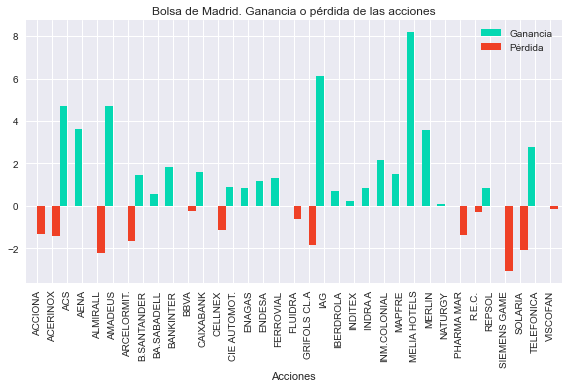

-0.23


In [21]:
       
class bolsaMadrid(Origen):
    campo_nombre = 'Nombre'
    campo_valorMaximo = 'Máx'
    campo_valorMinimo = 'Mín'
    campo_UltimoPrecio = 'Últ'
    campo_cambio = '% Dif'
    
    def __init__(self):
        super().__init__()

    def actualizarBD(self):
        #Hacemos la consulta a la pagina y guardamos el contenido en una variable soup
        url_page = 'https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000'
        page = requests.get(url_page).text 
        soup = BeautifulSoup(page, "lxml")

        #Buscamos la tabla de donde obtener los datos
        tabla = soup.find('table', attrs={'id': 'ctl00_Contenido_tblAcciones'})

        #creamos una lista vacia que llenaremos con los datos de las tablas
        columnas = []

        #buscamos los encabezados de la tabla y los agregamos a la lista columnos (deberia ubicarse en la posicion 0)
        headers = []
        for th in tabla.find_all('th'):
            headers.append(th.text.replace('.',''))
        columnas.append(headers)

        for tr in tabla.find_all('tr'):
            fila = []
            for td in tr.find_all('td'):
                fila.append(td.text)
            if len(fila) > 0:
                columnas.append(fila)
                
        #creamos el dataframe usando la lista columnas,pasamos el contenido (de la posicion 1 en adelante), y lo encabezados en (posicion 0)
        df = pd.DataFrame(columnas[1:], columns=columnas[0])

        #Convertirmos a float
        df = self.__convertirAFloat(df)

        #Guardamos los datos en la base de datos
        self._guardarEnBD(df)
        
    def __convertirAFloat(self, df):
        df["% Dif"] = df["% Dif"].str.replace(",", ".").astype(float)
        df["Máx"] = df["Máx"].str.replace(",", ".").astype(float)
        df["Mín"] = df["Mín"].str.replace(",", ".").astype(float)
        df["Últ"] = df["Últ"].str.replace(",", ".").astype(float)
        return df

nombreDeAcciones =[
    'BBVA', "BBVA.MC",
    'ELE', "ELE.MC", 'ENDESA',
    'GRLS', "GRF.MC", 'GRIFOLS CL.A',
    'INDRA A', 'IDR',"IDR.MC",
    "REP.MC", 'REP','REPSOL'
    ]

bolsamadrid = bolsaMadrid()
bolsamadrid.actualizarBD()
bolsamadrid.filtrarAcciones(nombreDeAcciones)
bolsamadrid.gananciaPerdidaAcciones('% Dif',2)
bolsamadrid.graficarGananciaPerdida(x='Nombre', y='% Dif', titulo='Bolsa de Madrid. Ganancia o pérdida de las acciones', nombre='Ganan_perd_BolsaMadrid_1.png')
accion = bolsamadrid.accion('BBVA')
print(accion.mov)

In [11]:
class yfinance(Origen):

    def __init__(self):
        super().__init__()
        self.campo_nombre = 'Ticker'
        self.campo_valorMaximo = 'High'
        self.campo_valorMinimo = 'Low'
        self.campo_UltimoPrecio = 'Close'
        self.campo_cambio = 'Dif'

    def actualizarBD(self, acciones):
        df_list = list()
        for accion in acciones:
            if not " " in accion and ".MC" in accion:
                data = yf.download(accion, group_by='ticker', period='1d')
                if not data.empty:
                    data['Ticker'] = accion
                    data['Dif'] = self.__calcularDiferencia(data['Open'], data['Close'])
                    df_list.append(data)

        if len(df_list) > 0:
            df = pd.concat(df_list)
            self._guardarEnBD(df)
    
    def __calcularDiferencia(self, A, B):
        return (B*100)/A-100

yahooFinance = yfinance()
yahooFinance.actualizarBD(nombreDeAcciones)
yahooFinance.visualizarBD()
yahooFinance.visualizarDF()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'_id': ObjectId('61868fbfc3ff66a5c4acc04a'), 'Open': 6.0279998779296875, 'High': 6.10699987411499, 'Low': 5.997000217437744, 'Close': 6.026000022888184, 'Adj Close': 6.026000022888184, 'Volume': 17151928, 'Ticker': 'BBVA.MC', 'Dif': -0.03317609625086959}
{'_id': ObjectId('61868fbfc3ff66a5c4acc04b'), 'Open': 20.0, 'High': 20.200000762939453, 'Low': 19.885000228881836, 'Close': 20.0, 'Adj Close': 20.0, 'Volume': 1218005, 'Ticker': 'ELE.MC', 'Dif': 0.0}
{'_id': ObjectId('61868fbfc3ff66a5c4acc04c'), 'Open': 18.700000762939453, 'High': 18.850000381469727, 'Low': 18.15999984741211, 'Close': 18.5, 'Adj Close': 18.5, 'Volume': 1845287, 'Ticker': 'GRF.MC'

,Open,High,Low,Close,Adj Close,Volume,Ticker,Dif
0,6.028000,6.107000,5.997,6.026,6.026,17151928,BBVA.MC,-0.033176
1,20.000000,20.200001,19.885,20.000,20.000,1218005,ELE.MC,0.000000
2,18.700001,18.850000,18.160,18.500,18.500,1845287,GRF.MC,-1.069523
3,10.670000,10.900000,10.640,10.780,10.780,1009845,IDR.MC,1.030925
4,10.710000,10.878000,10.584,10.812,10.812,8242619,REP.MC,0.952383


  country     name symbol    last    high     low  change change_percentage  \
0   spain     BBVA   BBVA   6.026   6.107   5.997  -0.014            -0.23%   
1   spain  Grifols   GRLS  18.480  18.805  18.185  -0.390            -2.07%   
2   spain   Repsol    REP  10.830  10.881  10.585  +0.145            +1.36%   
3   spain  Indra A    IDR  10.760  10.900  10.640  +0.100            +0.94%   
4   spain   Endesa    ELE  20.020  20.190  19.887  +0.200            +1.01%   

   turnover currency    GP  %  
0  16149999      EUR -0.23  %  
1   1850000      EUR -2.07  %  
2   5970000      EUR  1.36  %  
3   1010000      EUR  0.94  %  
4   1220000      EUR  1.01  %  

Acciones de mayor ganancia
    country     name symbol    last   high     low  change change_percentage  \
27   spain      IAG   ICAG   2.095   2.10   1.903  +0.121            +6.13%   
30   spain  Amadeus    AMA  61.830  62.39  57.389  +3.011            +5.12%   

    turnover currency    GP  %  
27  40720000      EUR  6.13  %  


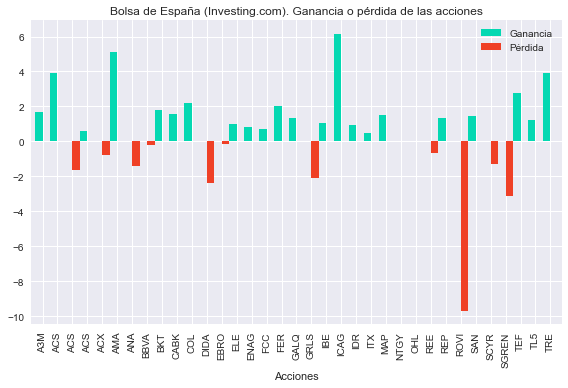

' invest.visualizarBD()\ninvest.visualizarDF() '

In [12]:
class investPy(Origen):

    def __init__(self):
        super().__init__()
        self.campo_nombre = 'symbol'
        self.campo_valorMaximo = 'high'
        self.campo_valorMinimo = 'low'
        self.campo_UltimoPrecio = 'last'
        self.campo_cambio = 'DP'

    def actualizarBD(self):
        df = investpy.stocks.get_stocks_overview(country='spain', as_json = False , n_results = 35)  
        df = self.__porcentajeCambio(df)
        #cambiar la columna a numérica
        df['GP'] = df['GP'].apply(pd.to_numeric)
        self._guardarEnBD(df)
    
    def __porcentajeCambio(self, df):
        return df.join(df['change_percentage'].str.partition('%')[[0, 1]]).rename({0: 'GP', 1: '%'}, axis=1)

invest = investPy()
invest.actualizarBD()
invest.filtrarAcciones(nombreDeAcciones)
invest.gananciaPerdidaAcciones('GP',2)
invest.graficarGananciaPerdida(x='symbol', y='GP', titulo='Bolsa de España (Investing.com). Ganancia o pérdida de las acciones', nombre='Ganan_perd_Investpy_1.png')
""" invest.visualizarBD()
invest.visualizarDF() """


In [624]:
class Cotizaciones(bolsaMadrid, yfinance, investPy):

    def __init__(self, acciones):
        self.acciones = acciones
        self.actualizarBD()
       

    def actualizarBD(self):
        bolsaMadrid.obtenerDatos(self)
        yfinance.obtenerDatos(self.acciones)
        ##investpy.obtenerDatos(self)

    def leerDatos():
        pass

In [625]:
acciones = ['ACCIONA', 'BBVA', 'GRIFOLS CL.A', 'PEPITO', 'REPSOL', 'ENDESA']
cotizaciones = Cotizaciones(acciones)
cotizaciones.mostrarDatosEnPantalla()


AttributeError: type object 'bolsaMadrid' has no attribute 'obtenerDatos'